In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sns.set_theme(style="whitegrid")

In [37]:
order_item = pd.read_csv("../../../downloads/olist_redefined/order_item.tsv", sep='\t').drop_duplicates()
order_item

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14
...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72


In [38]:
# order_product = order_item[['order_id','product_id', 'seller_id', 'price', 'freight_value']]
order_product = order_item.drop(columns=['shipping_limit_date'])
order_product

,order_id,order_item_id,product_id,seller_id,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,199.90,18.14
...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,299.99,43.41
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,350.00,36.53
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,99.90,16.95
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,55.99,8.72


In [39]:
order_product.drop_duplicates().shape

(112650, 6)

In [40]:
order_product['product_id'].nunique()

32951

In [41]:
product = pd.read_csv("../../../downloads/olist_redefined/product.tsv", sep='\t').drop_duplicates()
product

,product_id,weight_g,length_cm,height_cm,width_cm,category
0,18ea29d5e42eea2c720cafb650f572f3,50.0,16.0,6.0,13.0,agro_industry_and_commerce
1,a79e27ad902bfc67386ea63ed1ef7a08,100.0,16.0,5.0,11.0,agro_industry_and_commerce
2,a0fe1efb855f3e786f0650268cd77f44,125.0,20.0,4.0,13.0,agro_industry_and_commerce
3,ac4bd2aec3f990363aa853e4f17709d3,150.0,18.0,8.0,13.0,agro_industry_and_commerce
4,a6bfd5412c292e6ab465ba7d7f794727,200.0,16.0,2.0,20.0,agro_industry_and_commerce
...,...,...,...,...,...,...
32946,8ef13bdd5d6da4bc50df1aaa486bf922,25800.0,34.0,84.0,54.0,NaN
32947,ea11e700a343582ad56e4c70e966cb36,26000.0,67.0,57.0,46.0,NaN
32948,ace8fb267a4f76c58dad79d0171f6812,26950.0,65.0,79.0,29.0,NaN
32949,ceeba7d5636e59173cc5f484e913db3d,30000.0,65.0,65.0,65.0,NaN


In [42]:
product['product_id'].nunique()

32951

In [43]:
order_product_info = order_product.merge(product, on='product_id', how='inner').drop_duplicates()
order_product_info

,order_id,order_item_id,product_id,seller_id,price,freight_value,weight_g,length_cm,height_cm,width_cm,category
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.90,13.29,650.0,28.0,9.0,14.0,cool_stuff
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,239.90,19.93,30000.0,50.0,30.0,40.0,pet_shop
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,199.00,17.87,3050.0,33.0,13.0,33.0,furniture_decor
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,12.99,12.79,200.0,16.0,10.0,15.0,perfumery
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,199.90,18.14,3750.0,35.0,40.0,30.0,garden_tools
...,...,...,...,...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,299.99,43.41,10150.0,89.0,15.0,40.0,housewares
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,350.00,36.53,8950.0,45.0,26.0,38.0,computers_accessories
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,99.90,16.95,967.0,21.0,24.0,19.0,sports_leisure
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,55.99,8.72,100.0,20.0,20.0,20.0,computers_accessories


In [44]:
order_product_info.isna().value_counts()

order_id  order_item_id  product_id  seller_id  price  freight_value  weight_g  length_cm  height_cm  width_cm  category
False     False          False       False      False  False          False     False      False      False     False       111046
                                                                                                                True          1586
                                                                      True      True       True       True      True            17
                                                                                                                False            1
Name: count, dtype: int64

In [45]:
null_product_category = order_product_info[order_product_info['category'].isna()]
null_product_category_seller = null_product_category['seller_id'].unique()

In [46]:
order_info_of_null_product_category_seller = order_product_info[order_product_info['seller_id'].isin(null_product_category_seller)]
order_info_of_null_product_category_seller

,order_id,order_item_id,product_id,seller_id,price,freight_value,weight_g,length_cm,height_cm,width_cm,category
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,239.90,19.93,30000.0,50.0,30.0,40.0,pet_shop
39,0017afd5076e074a48f1f1a4c7bac9c5,1,fe59a1e006df3ac42bf0ceb876d70969,25c5c91f63607446a97b143d2d535d31,809.10,44.29,3407.0,28.0,22.0,23.0,computers_accessories
48,001d8f0e34a38c37f7dba2a37d4eba8b,1,e67307ff0f15ade43fcb6e670be7a74c,f4aba7c0bca51484c30ab7bdc34bcdd1,18.99,7.78,150.0,43.0,13.0,14.0,health_beauty
49,001d8f0e34a38c37f7dba2a37d4eba8b,2,e67307ff0f15ade43fcb6e670be7a74c,f4aba7c0bca51484c30ab7bdc34bcdd1,18.99,7.78,150.0,43.0,13.0,14.0,health_beauty
65,00275bce676303c3bfd7292aefdfa223,1,6490b9f63b0b595e1c1402b46b0f50ad,99eaacc9e6046db1c82b163c5f84869f,279.90,13.46,300.0,18.0,10.0,13.0,telephony
...,...,...,...,...,...,...,...,...,...,...,...
112585,ffdc30c0eaeed2e08818c4dad9806292,1,c3f6113d5b61bc95468432072b27e23d,897060da8b9a21f655304d50fd935913,18.90,15.10,300.0,36.0,9.0,11.0,computers_accessories
112592,ffde92ba447b33a47d1c04d203f10f41,1,a97cd00f5c1dbfbc7f0f4b6c1032253e,b347677812ea483b0f528eaf8cbc09b7,278.00,26.70,5500.0,51.0,20.0,29.0,housewares
112618,ffed7e90414c1477a6b92554661d465f,1,550dc4417c636abc04c71404342de695,25c5c91f63607446a97b143d2d535d31,149.90,16.81,1238.0,34.0,19.0,24.0,computers_accessories
112634,fff8287bbae429a99bb7e8c21d151c41,1,bee2e070c39f3dd2f6883a17a5f0da45,4e922959ae960d389249c378d1c939f5,180.00,48.14,175.0,20.0,20.0,20.0,computers_accessories


In [47]:
totl_selling_product_count_by_seller = order_info_of_null_product_category_seller.groupby('seller_id').agg({'product_id': 'count'})
totl_selling_product_count_by_seller.rename(columns={'product_id': "total_selling_produt_count"}, inplace=True)
totl_selling_product_count_by_seller.sort_values('total_selling_produt_count', ascending=False)

,total_selling_produt_count
seller_id,
f8db351d8c4c4c22c6835c19a46f01b0,724
391fc6631aebcf3004804e51b40bcf1e,613
46dc3b2cc0980fb8ec44634e21d2718e,542
53e4c6e0f4312d4d2107a8c9cddf45cd,522
4e922959ae960d389249c378d1c939f5,454
...,...
38f276ca6e7cc95a6d1bb55ac9e5550f,1
2f3d8b4c9e2ee165075331fea3f3095a,1
1a6245add4353f18ed55138808906979,1


In [48]:
totl_selling_product_count_by_seller[totl_selling_product_count_by_seller['total_selling_produt_count'] > 1].value_counts()

total_selling_produt_count
3                             27
2                             20
11                            13
7                             12
8                             10
                              ..
454                            1
522                            1
542                            1
613                            1
724                            1
Name: count, Length: 78, dtype: int64

In [49]:
tmp = order_info_of_null_product_category_seller.groupby('seller_id').agg({'category': 'nunique'}).sort_values('category')
tmp[tmp['category']==1]

,category
seller_id,
38e6dada03429a47197d5d584d793b41,1
3771c85bac139d2344864ede5d9341e3,1
4200ddf1967c5e41e48db62bc6d4b5ac,1
3f8034bfc6b8b4135534975d49f04c63,1
d9cb0052a666de5308b32f32ad5f1b1c,1
...,...
92c8bc6e8f925792247656fed09aad65,1
82e0a475a88cc9595229d8029273f045,1
8ca5b19e0263150d2c57afdde2b3d011,1


In [50]:
tmp = order_product_info[order_product_info.seller_id == "4e922959ae960d389249c378d1c939f5"]
tmp['category'].unique()

array(['telephony', 'agro_industry_and_commerce', 'computers_accessories',
       'pet_shop', 'consoles_games', 'auto', 'cool_stuff',
       'cds_dvds_musicals', 'electronics', nan, 'housewares',
       'sports_leisure', 'health_beauty', 'audio', 'fixed_telephony',
       'furniture_decor', 'watches_gifts', 'signaling_and_security',
       'garden_tools', 'christmas_supplies', 'musical_instruments',
       'security_and_services', 'food', 'home_appliances'], dtype=object)

판매자의 물품의 카테고리가 정의되어 있지 않은 경우에, 그 판매자가 판매 중인 모든 제품의 카테고리와 크기, 무게를 비교하여 넣으려고 했으나, 완벽한(100%) 추정이 아니므로 제외 결정

In [51]:
clean_order_product_info = order_product_info.dropna()
clean_order_product_info

,order_id,order_item_id,product_id,seller_id,price,freight_value,weight_g,length_cm,height_cm,width_cm,category
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.90,13.29,650.0,28.0,9.0,14.0,cool_stuff
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,239.90,19.93,30000.0,50.0,30.0,40.0,pet_shop
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,199.00,17.87,3050.0,33.0,13.0,33.0,furniture_decor
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,12.99,12.79,200.0,16.0,10.0,15.0,perfumery
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,199.90,18.14,3750.0,35.0,40.0,30.0,garden_tools
...,...,...,...,...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,299.99,43.41,10150.0,89.0,15.0,40.0,housewares
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,350.00,36.53,8950.0,45.0,26.0,38.0,computers_accessories
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,99.90,16.95,967.0,21.0,24.0,19.0,sports_leisure
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,55.99,8.72,100.0,20.0,20.0,20.0,computers_accessories


In [52]:
# 판매 가격 변동이 있는 제품. 원인은 모름
tmp = clean_order_product_info.groupby('product_id', as_index=False).agg(price_count=('price', 'nunique'))
price_changed = tmp[tmp['price_count'] > 1]
price_changed.shape


(5832, 2)

In [53]:
price_changed['price_count'].value_counts()

price_count
2     4071
3     1036
4      383
5      141
6       75
7       44
8       30
9       10
13       7
10       7
12       6
11       6
21       3
20       2
17       2
23       2
14       2
16       1
31       1
15       1
29       1
27       1
Name: count, dtype: int64

In [54]:
# 동일 상품을 여러 판매자가 판매하는 경우도 있음
max_price_changed_product_id = price_changed[price_changed['price_count'] == 27]['product_id'].values[0]
order_product_info[order_product_info['product_id'] == max_price_changed_product_id]['seller_id'].unique()

array(['7d13fca15225358621be4086e1eb0964',
       '4869f7a5dfa277a7dca6462dcf3b52b2',
       '7e93a43ef30c4f03f38b393420bc753a',
       '2eb70248d66e0e3ef83659f71b244378',
       'fa1c13f2614d7b5c4749cbc52fecda94'], dtype=object)

In [55]:
price_dist = clean_order_product_info['price'].value_counts()
price_dist

price
59.90     2461
69.90     1978
49.90     1933
89.90     1534
99.90     1419
          ... 
89.24        1
109.66       1
640.99       1
442.95       1
54.28        1
Name: count, Length: 5901, dtype: int64

# sales

In [56]:
clean_orders = clean_order_product_info.drop(columns=['weight_g','length_cm','height_cm','width_cm'])
clean_orders['selling_price'] = clean_orders['price'] + clean_orders['freight_value']
clean_orders

,order_id,order_item_id,product_id,seller_id,price,freight_value,category,selling_price
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.90,13.29,cool_stuff,72.19
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,239.90,19.93,pet_shop,259.83
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,199.00,17.87,furniture_decor,216.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,12.99,12.79,perfumery,25.78
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,199.90,18.14,garden_tools,218.04
...,...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,299.99,43.41,housewares,343.40
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,350.00,36.53,computers_accessories,386.53
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,99.90,16.95,sports_leisure,116.85
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,55.99,8.72,computers_accessories,64.71


In [57]:
order_status = pd.read_csv("../../../downloads/olist_redefined/order_status.tsv", sep='\t').drop_duplicates()
complete_order = order_status[order_status['status'] == 'delivered_customer']
complete_order

,order_id,status,timestamp
710,36989eb07a0de2d3d3129eea35553875,delivered_customer,2016-10-11 13:46:32.000000
711,7033745709b7cf1bac7d2533663592de,delivered_customer,2016-10-11 14:46:49.000000
749,d1eb8e4e276a4eea13a5c462c0765e60,delivered_customer,2016-10-13 03:10:34.000000
751,92b44b87f1f7670b8911c5f0e642435e,delivered_customer,2016-10-13 07:45:48.000000
756,ac2b7c522d811acba0aa270ed3e112e4,delivered_customer,2016-10-13 15:44:27.000000
...,...,...,...
395817,7d09831e67caa193da82cfea3bee7aa5,delivered_customer,2018-09-25 00:47:25.000000
395821,a2b4be96b53022618030c17ed437604d,delivered_customer,2018-09-27 02:24:33.000000
395826,b2997e1d7061605e9285496c581d1fbd,delivered_customer,2018-10-02 00:18:50.000000
395830,450cb96c63e1e5b49d34f223f67976d2,delivered_customer,2018-10-11 16:41:14.000000


In [58]:
payment = pd.read_csv("../../../downloads/olist_redefined/payment.tsv", sep='\t').drop_duplicates()
complete_payment = payment[payment['order_id'].isin(complete_order['order_id'])]
complete_payment = complete_payment.sort_values(['order_id', 'payment_sequential']).drop_duplicates()
complete_payment

,timestamp,order_id,customer_id,payment_sequential,payment_installments,payment_type,payment_value
26545,2017-09-13 08:59:02,00010242fe8c5a6d1ba2dd792cb16214,871766c5855e863f6eccc05f988b23cb,1,2,credit_card,72.19
8058,2017-04-26 10:53:06,00018f77f2f0320c557190d7a144bdd3,eb28e67c4c0b83846050ddfb8a35d051,1,3,credit_card,259.83
51008,2018-01-14 14:33:31,000229ec398224ef6ca0657da4fc703e,3818d81c6709e39d06b2738a8d3a2474,1,5,credit_card,216.87
99468,2018-08-08 10:00:35,00024acbcdf0a6daa1e931b038114c75,af861d436cfc08b2c2ddefd0ba074622,1,2,credit_card,25.78
1433,2017-02-04 13:57:51,00042b26cf59d7ce69dfabb4e55b4fd9,64b576fb70d441e8f1b2d7d446e483c5,1,3,credit_card,218.04
...,...,...,...,...,...,...,...
75247,2018-04-23 13:57:06,fffc94f6ce00a00581880bf54a75a037,0c9aeda10a71f369396d0c04dce13a64,1,1,boleto,343.40
92815,2018-07-14 10:26:46,fffcd46ef2263f404302a634eb57f7eb,0da9fe112eae0c74d3ba1fe16de0988b,1,1,boleto,386.53
32866,2017-10-23 17:07:56,fffce4705a9662cd70adb13d4a31832d,cd79b407828f02fdbba457111c38e4c4,1,3,credit_card,116.85
22214,2017-08-14 23:02:59,fffe18544ffabc95dfada21779c9644f,eb803377c9315b564bdedad672039306,1,3,credit_card,64.71


In [59]:
complete_revenue = complete_payment.groupby('order_id', as_index=False).agg(revenue=('payment_value', 'sum'))
complete_revenue

,order_id,revenue
0,00010242fe8c5a6d1ba2dd792cb16214,72.19
1,00018f77f2f0320c557190d7a144bdd3,259.83
2,000229ec398224ef6ca0657da4fc703e,216.87
3,00024acbcdf0a6daa1e931b038114c75,25.78
4,00042b26cf59d7ce69dfabb4e55b4fd9,218.04
...,...,...
96470,fffc94f6ce00a00581880bf54a75a037,343.40
96471,fffcd46ef2263f404302a634eb57f7eb,386.53
96472,fffce4705a9662cd70adb13d4a31832d,116.85
96473,fffe18544ffabc95dfada21779c9644f,64.71


In [60]:
complete_sales = clean_orders[clean_orders['order_id'].isin(complete_revenue['order_id'])]
complete_sales.sort_values(['order_id', 'product_id'])

,order_id,order_item_id,product_id,seller_id,price,freight_value,category,selling_price
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.90,13.29,cool_stuff,72.19
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,239.90,19.93,pet_shop,259.83
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,199.00,17.87,furniture_decor,216.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,12.99,12.79,perfumery,25.78
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,199.90,18.14,garden_tools,218.04
...,...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,299.99,43.41,housewares,343.40
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,350.00,36.53,computers_accessories,386.53
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,99.90,16.95,sports_leisure,116.85
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,55.99,8.72,computers_accessories,64.71


In [61]:
total_sales_by_category = complete_sales.groupby('category', as_index=False).agg(total_selling_price=('selling_price', 'sum'))
total_sales_by_category = total_sales_by_category.sort_values('total_selling_price', ascending=False)
total_sales_by_category['proportion'] = total_sales_by_category['total_selling_price'] / total_sales_by_category['total_selling_price'].sum() * 100

In [62]:
# health_beauty 카테고리에서 제품별 비중
health_beauty_order = complete_sales[complete_sales['category'] == 'health_beauty']
health_beauty_order

,order_id,order_item_id,product_id,seller_id,price,freight_value,category,selling_price
8,0005a1a1728c9d785b8e2b08b904576c,1,310ae3c140ff94b03219ad0adc3c778f,a416b6a846a11724393025641d4edd5e,145.95,11.65,health_beauty,157.60
10,00061f2a7bc09da83e415a52dc8a4af1,1,d63c1011f49d98b976c352955b1c4bea,cc419e0650a3c5ba77189a1882b7556a,59.99,8.88,health_beauty,68.87
48,001d8f0e34a38c37f7dba2a37d4eba8b,1,e67307ff0f15ade43fcb6e670be7a74c,f4aba7c0bca51484c30ab7bdc34bcdd1,18.99,7.78,health_beauty,26.77
49,001d8f0e34a38c37f7dba2a37d4eba8b,2,e67307ff0f15ade43fcb6e670be7a74c,f4aba7c0bca51484c30ab7bdc34bcdd1,18.99,7.78,health_beauty,26.77
53,001e7cf2ad6bef3ade12ebc56ceaf0f3,1,bdcf6a834e8faa30dac3886c7a58e92e,2a84855fd20af891be03bc5924d2b453,35.90,15.20,health_beauty,51.10
...,...,...,...,...,...,...,...,...
112566,ffce8a2dd7579795f5c1cbe2bf23d51d,1,00878d953636afec00d3e85d55a12e7f,955fee9216a65b617aa5c0531780ce60,100.00,26.78,health_beauty,126.78
112589,ffdd178654127ccf34a439e8704fecd9,1,16b4473e98422039c388f144a0b16f55,4de6e4ba574aa9dfdc824bc44dc47fdd,69.90,38.71,health_beauty,108.61
112595,ffe146c862ce518ad378598499bf9204,1,8ab83b53b9a953395f4f21f0b1a845ef,431050a06a317f2b38168dec3dcd2b46,83.80,18.69,health_beauty,102.49
112614,ffec1a6d35149778ec575d5048d44db8,1,437c05a395e9e47f9762e677a7068ce7,f84fa566034f5e8e880a07ec624c56af,47.65,7.39,health_beauty,55.04


In [63]:
popular_product = health_beauty_order.groupby('product_id', as_index=False).agg(total_selling_price=('selling_price', 'sum'), order_count=('order_id', 'count')).sort_values('total_selling_price', ascending=False)
popular_product['avg_price'] = popular_product['total_selling_price'] / popular_product['order_count']
popular_product['total_selling_price_cumsum'] = popular_product['total_selling_price'].cumsum()
popular_product['total_selling_price_proportion'] = popular_product['total_selling_price'] / popular_product['total_selling_price'].sum()
popular_product['total_selling_price_proportion_cumsum'] = popular_product['total_selling_price_proportion'].cumsum()
popular_product

,product_id,total_selling_price,order_count,avg_price,total_selling_price_cumsum,total_selling_price_proportion,total_selling_price_proportion_cumsum
1742,bb50f2e236e5eea0100680137654686c,67258.03,194,346.690876,67258.03,0.047631,0.047631
1000,6cdd53843498f92890544667809f1595,57933.73,153,378.651830,125191.76,0.041028,0.088658
408,2b4609f8948be18874494203496bc318,26127.92,255,102.462431,151319.68,0.018503,0.107162
257,19c91ef95d509ea33eda93495c4d3481,24038.01,154,156.090974,175357.69,0.017023,0.124185
1158,7c1bd920dbdf22470b68bde975dd3ccf,16735.70,220,76.071364,192093.39,0.011852,0.136037
...,...,...,...,...,...,...,...
1137,79ce45dbc2ea29b22b5a261bbb7b7ee7,14.37,1,14.370000,1412024.16,0.000010,0.999968
12,01b0238705b6ae8e35c6fea837e6ae4a,13.49,1,13.490000,1412037.65,0.000010,0.999977
2057,da86f3242cb55a55dd9cd7b19d951685,12.28,1,12.280000,1412049.93,0.000009,0.999986
1374,9334fc63bffa67f685c03b1dc24df180,10.48,1,10.480000,1412060.41,0.000007,0.999993


In [64]:
popular_product[popular_product['product_id'] == '154e7e31ebfa092203795c972e5804a6']

,product_id,total_selling_price,order_count,avg_price,total_selling_price_cumsum,total_selling_price_proportion,total_selling_price_proportion_cumsum
207,154e7e31ebfa092203795c972e5804a6,9824.2,274,35.854745,301760.25,0.006957,0.213701


In [65]:
popular_product_sorted = popular_product.sort_values('total_selling_price', ascending=False).reset_index(drop=True)
total_products = len(popular_product_sorted)
popular_product_sorted['product_rank'] = popular_product_sorted.index + 1
popular_product_sorted['rank_proportion'] = popular_product_sorted['product_rank'] / total_products
popular_product_sorted

,product_id,total_selling_price,order_count,avg_price,total_selling_price_cumsum,total_selling_price_proportion,total_selling_price_proportion_cumsum,product_rank,rank_proportion
0,bb50f2e236e5eea0100680137654686c,67258.03,194,346.690876,67258.03,0.047631,0.047631,1,0.000417
1,6cdd53843498f92890544667809f1595,57933.73,153,378.651830,125191.76,0.041028,0.088658,2,0.000834
2,2b4609f8948be18874494203496bc318,26127.92,255,102.462431,151319.68,0.018503,0.107162,3,0.001252
3,19c91ef95d509ea33eda93495c4d3481,24038.01,154,156.090974,175357.69,0.017023,0.124185,4,0.001669
4,7c1bd920dbdf22470b68bde975dd3ccf,16735.70,220,76.071364,192093.39,0.011852,0.136037,5,0.002086
...,...,...,...,...,...,...,...,...,...
2392,79ce45dbc2ea29b22b5a261bbb7b7ee7,14.37,1,14.370000,1412024.16,0.000010,0.999968,2393,0.998331
2393,01b0238705b6ae8e35c6fea837e6ae4a,13.49,1,13.490000,1412037.65,0.000010,0.999977,2394,0.998748
2394,da86f3242cb55a55dd9cd7b19d951685,12.28,1,12.280000,1412049.93,0.000009,0.999986,2395,0.999166
2395,9334fc63bffa67f685c03b1dc24df180,10.48,1,10.480000,1412060.41,0.000007,0.999993,2396,0.999583


In [66]:
top_product = popular_product_sorted[popular_product_sorted['total_selling_price_proportion_cumsum'] <= 0.8]
top_product
# top_product.to_csv('top80.csv',index=False)

,product_id,total_selling_price,order_count,avg_price,total_selling_price_cumsum,total_selling_price_proportion,total_selling_price_proportion_cumsum,product_rank,rank_proportion
0,bb50f2e236e5eea0100680137654686c,67258.03,194,346.690876,67258.03,0.047631,0.047631,1,0.000417
1,6cdd53843498f92890544667809f1595,57933.73,153,378.651830,125191.76,0.041028,0.088658,2,0.000834
2,2b4609f8948be18874494203496bc318,26127.92,255,102.462431,151319.68,0.018503,0.107162,3,0.001252
3,19c91ef95d509ea33eda93495c4d3481,24038.01,154,156.090974,175357.69,0.017023,0.124185,4,0.001669
4,7c1bd920dbdf22470b68bde975dd3ccf,16735.70,220,76.071364,192093.39,0.011852,0.136037,5,0.002086
...,...,...,...,...,...,...,...,...,...
538,0e56431285bc62af798b89f6650d23f9,441.86,2,220.930000,1127679.68,0.000313,0.798600,539,0.224864
539,ba01cebc5a3c2494d0a97d4713ec8938,441.25,2,220.625000,1128120.93,0.000312,0.798913,540,0.225282
540,ede062bcd13ef64b5cc87369e4edaf62,440.93,11,40.084545,1128561.86,0.000312,0.799225,541,0.225699
541,b66270a5d5b3a8585f8314b2f14420fb,439.30,7,62.757143,1129001.16,0.000311,0.799536,542,0.226116


In [67]:
top_product['total_selling_price'].describe()

count      543.000000
mean      2079.999374
std       4551.851002
min        438.500000
25%        598.090000
50%        929.560000
75%       1833.240000
max      67258.030000
Name: total_selling_price, dtype: float64

In [68]:
popular_product_sorted['order_count'].describe()

count    2397.000000
mean        3.948269
std        13.345380
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max       274.000000
Name: order_count, dtype: float64

--- Analysis Thresholds (Full Dataset, Revised) ---
Order Count Threshold (Top 25%): 3.00
Median Average Price: 97.79

--- Group Definitions ---
- Star Products: 주문량과 판매가 모두 높은 제품. 매출의 핵심 동력.
- Volume Drivers: 주문량은 많지만 판매가는 낮은 제품. 폭넓은 고객층을 유인.
- Niche Gems: 주문량은 적지만 판매가는 높은 제품. 특정 고가치 시장을 공략.
- Question Marks: 주문량과 판매가 모두 낮은 제품. 전체 매출에 미치는 영향이 비교적 적음.
-------------------------

--- Product Count by Group (Full Dataset) ---
group
Niche Gems        873
Question Marks    859
Volume Drivers    339
Star Products     326
Name: count, dtype: int64


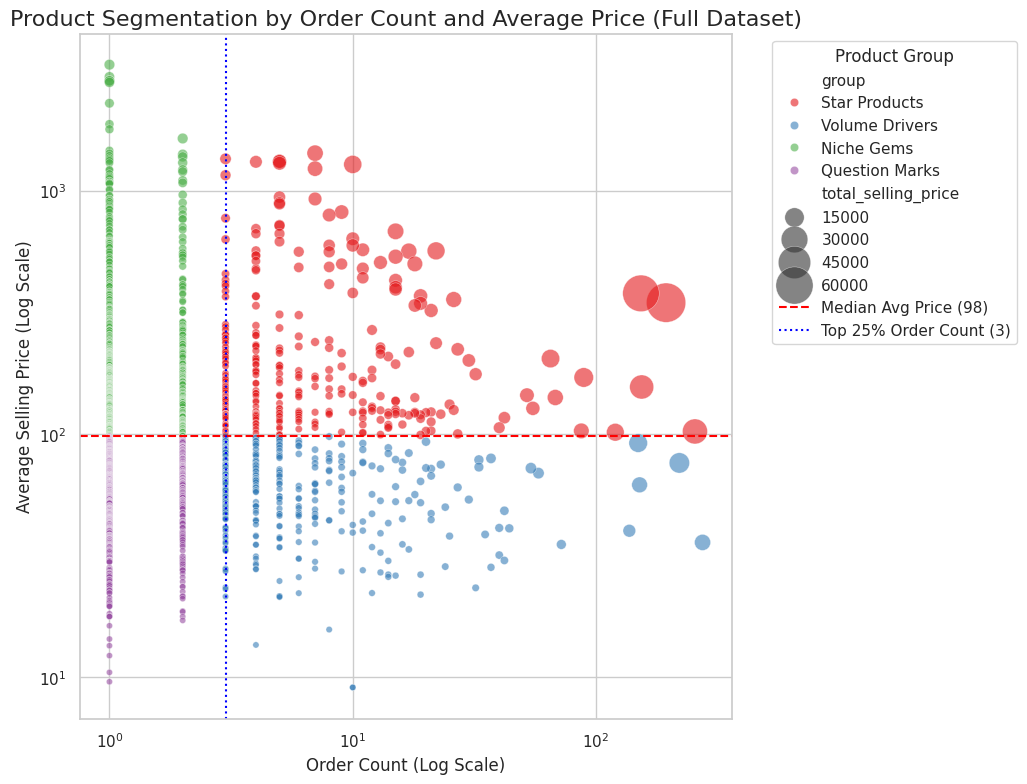

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 가정: 'popular_product_sorted' 변수에 전체 2397건의 데이터가 로드되어 있다고 가정합니다.
# 이 데이터프레임에는 'order_count', 'avg_price', 'total_selling_price' 열이 있어야 합니다.

# 1. 그룹 분류 기준점 재설정
# 주문 수 기준: 상위 25% (75th percentile)를 사용하여 '많이 팔림'을 정의
order_count_threshold = popular_product_sorted['order_count'].quantile(0.75)
# 평균 판매가 기준: 중앙값(median)을 그대로 사용
median_avg_price = popular_product_sorted['avg_price'].median()

print("--- Analysis Thresholds (Full Dataset, Revised) ---")
print(f"Order Count Threshold (Top 25%): {order_count_threshold:.2f}")
print(f"Median Average Price: {median_avg_price:.2f}\n")


# 2. 제품을 4개 그룹으로 분류하는 함수 정의 (기준점 변수명 변경)
def classify_product_english(row):
    is_high_volume = row['order_count'] >= order_count_threshold # 변경된 기준점 사용
    is_high_price = row['avg_price'] >= median_avg_price
    
    if is_high_volume and is_high_price:
        return 'Star Products'
    elif is_high_volume and not is_high_price:
        return 'Volume Drivers'
    elif not is_high_volume and is_high_price:
        return 'Niche Gems'
    else:
        return 'Question Marks'

# 3. 함수를 적용하여 'group' 열 생성
popular_product_sorted['group'] = popular_product_sorted.apply(classify_product_english, axis=1)

# --- 명확성을 위해 그룹 정의를 정의하고 표시 ---
group_definitions = {
    'Star Products': '주문량과 판매가 모두 높은 제품. 매출의 핵심 동력.',
    'Volume Drivers': '주문량은 많지만 판매가는 낮은 제품. 폭넓은 고객층을 유인.',
    'Niche Gems': '주문량은 적지만 판매가는 높은 제품. 특정 고가치 시장을 공략.',
    'Question Marks': '주문량과 판매가 모두 낮은 제품. 전체 매출에 미치는 영향이 비교적 적음.'
}

print("--- Group Definitions ---")
for group, definition in group_definitions.items():
    print(f"- {group}: {definition}")
print("-" * 25)

# 4. 전체 데이터에 대한 그룹 통계 표시
print("\n--- Product Count by Group (Full Dataset) ---")
print(popular_product_sorted['group'].value_counts())


# 5. 시각화
plt.figure(figsize=(10, 10))
plt.xscale('log')
plt.yscale('log')

sns.scatterplot(
    data=popular_product_sorted,
    x='order_count',
    y='avg_price',
    hue='group',
    size='total_selling_price',
    sizes=(20, 800), # 점의 최소 크기를 더 작게 조정하여 롱테일을 표현
    alpha=0.6, # 점이 많으므로 투명도를 살짝 높임
    palette='Set1'
)

plt.gca().set_aspect('equal', adjustable='box')

# 기준선도 새로운 기준으로 업데이트
plt.axhline(median_avg_price, color='red', linestyle='--', label=f'Median Avg Price ({median_avg_price:.0f})')
plt.axvline(order_count_threshold, color='blue', linestyle=':', label=f'Top 25% Order Count ({order_count_threshold:.0f})')

plt.title('Product Segmentation by Order Count and Average Price (Full Dataset)', fontsize=16)
plt.xlabel('Order Count (Log Scale)', fontsize=12)
plt.ylabel('Average Selling Price (Log Scale)', fontsize=12)
plt.legend(title='Product Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()

# plt.savefig('full_data_segmentation_chart.png')
# print("\nAnalysis chart for the full dataset has been saved as 'full_data_segmentation_chart.png'")



In [70]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np
# from sklearn.cluster import KMeans
# from sklearn.preprocessing import StandardScaler

# # 가정: 'popular_product_sorted' 변수에 전체 데이터가 로드되어 있다고 가정합니다.

# # --- 1. 데이터 준비 (K-Means를 위한 스케일링) ---
# # K-Means는 값의 범위(scale)에 민감하므로, 로그 변환과 표준화를 적용합니다.
# # 로그 변환은 데이터의 왜곡을 줄여줍니다.
# features = popular_product_sorted[['order_count', 'avg_price']].copy()
# log_features = features.apply(np.log1p)

# # 표준화는 각 변수의 중요도를 동등하게 만들어줍니다.
# scaler = StandardScaler()
# scaled_features = scaler.fit_transform(log_features)


# # --- 2. 최적의 클러스터 개수(K) 찾기 (Elbow Method) ---
# inertia = []
# k_range = range(1, 11)
# for k in k_range:
#     kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
#     kmeans.fit(scaled_features)
#     inertia.append(kmeans.inertia_)

# # Elbow Method 시각화
# plt.figure(figsize=(8, 5))
# plt.plot(k_range, inertia, marker='o')
# plt.title('Elbow Method for Optimal K')
# plt.xlabel('Number of Clusters (K)')
# plt.ylabel('Inertia')
# plt.grid(True)
# plt.show()
# # 그래프에서 팔꿈치처럼 꺾이는 지점이 최적의 K입니다. (보통 3, 4, 또는 5)


# # --- 3. K-Means 실행 및 클러스터 할당 ---
# # 위 그래프를 보고 최적의 K를 결정합니다. 여기서는 4로 가정하겠습니다.
# optimal_k = 4
# kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
# popular_product_sorted['cluster'] = kmeans.fit_predict(scaled_features)


# # --- 4. 결과 시각화 및 해석 ---
# print(f"\n--- Analysis Results with K={optimal_k} ---")

# # 각 클러스터의 통계적 특성 분석
# cluster_summary = popular_product_sorted.groupby('cluster')[['order_count', 'avg_price', 'total_selling_price']].mean().sort_values('total_selling_price', ascending=False)
# print("\n--- Mean Characteristics of Each Cluster ---")
# print(cluster_summary)

# # 클러스터링 결과 시각화
# plt.figure(figsize=(12, 10))
# plt.xscale('log')
# plt.yscale('log')

# sns.scatterplot(
#     data=popular_product_sorted,
#     x='order_count',
#     y='avg_price',
#     hue='cluster',  # 새로운 클러스터 기준으로 색상 구분
#     size='total_selling_price',
#     sizes=(20, 1000),
#     alpha=0.7,
#     palette='Set1' # 대비가 높은 색상 팔레트
# )

# plt.gca().set_aspect('equal', adjustable='box')

# plt.title(f'K-Means Clustering Results (K={optimal_k})', fontsize=16)
# plt.xlabel('Order Count (Log Scale)', fontsize=12)
# plt.ylabel('Average Selling Price (Log Scale)', fontsize=12)
# plt.legend(title='Cluster ID', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.grid(True)
# plt.tight_layout()

# plt.savefig('kmeans_clustering_result.png')
# print("\nK-Means clustering analysis chart saved as 'kmeans_clustering_result.png'")
